In [1]:
import numpy as np
import pandas as pd 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import math
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Loading all data

Loading all datasets used - main triplet data, embedded vectors generates with Poisson factotization, bridge data that connects TrackId with SongId and song genre data. 

In [3]:
# main triplet data
data = pd.read_csv("/content/drive/My Drive/MSc Statistics/train_triplets.txt",
                   delimiter="\t", header=None, names= ["UserId", "SongId", "Count"])

In [ ]:
data.head()

,UserId,SongId,Count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


In [ ]:
# embedded vectors data
embeds = np.load("/content/drive/My Drive/MSc Statistics/track-embeddings-v2.npz", allow_pickle=True)

"beta" part corresponds to the 100 dimensional embedded vectors and "mapping" - to the corresponding SongId

In [ ]:
#shape of the song vectors
embeds["beta"].shape

(384546, 100)

In [ ]:
# shape of the link vector
embeds["mapping"].shape

(384546,)

In [ ]:
# these link vectors correspond to SongId
embeds["mapping"][1]

'SOAPDEY12A81C210A9'

In [ ]:
# data to connect TrackId with SongId
bridge = pd.read_csv("/content/drive/My Drive/MSc Statistics/unique_tracks.txt",  delimiter="<SEP>", header=None, 
                    names= ["TrackId", "SongId", "Artist", "Song_name"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
bridge.head()

,TrackId,SongId,Artist,Song_name
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8,Faster Pussy cat,Silent Night
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9,Karkkiautomaatti,Tanssi vaan
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1,Hudson Mohawke,No One Could Ever
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C,Yerba Brava,Si Vos Querés
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF,Der Mystic,Tangle Of Aspens


In [ ]:
bridge.shape

(1000000, 4)

In [ ]:
# song genre data
genres = pd.read_csv("/content/drive/My Drive/MSc Statistics/ganres.txt",  delimiter="\t", header=None,
                     names= ["TrackId", "Main_genre", "Minor_genre"])

In [ ]:
genres.head()

,TrackId,Main_genre,Minor_genre
0,TRAAAAK128F9318786,Rock,NaN
1,TRAAAAW128F429D538,Rap,NaN
2,TRAAABD128F429CF47,Rock,RnB
3,TRAAADJ128F4287B47,Rock,NaN
4,TRAAADZ128F9348C2E,Latin,NaN


In [ ]:
genres.shape

(280831, 3)

# Data Analysis

We begin by analysing the main triplet data followed by the ganre data.

In [ ]:
print("Number of unique users", len(data["UserId"].unique().tolist()),
      "Number of unique tracks", len(data["SongId"].unique().tolist()))

Number of unique users 1019318 Number of unique tracks 384546


In [ ]:
pd.options.display.float_format = '{:.2f}'.format # supresing scientific notation
data["Count"].describe()

count   48373586.00
mean           2.87
std            6.44
min            1.00
25%            1.00
50%            1.00
75%            3.00
max         9667.00
Name: Count, dtype: float64

"Count" data has a large skew - 75th percentile is 3, yet the max values is 9667. Also, the majority of the data (at least 50% of it) is 1.

In [ ]:
print("Song playing count greater than 100:", np.sum(data["Count"]>100),". "
     "Song playing count greater than 1000:", np.sum(data["Count"]>1000))

Song playing count greater than 100: 18811 . Song playing count greater than 1000: 62


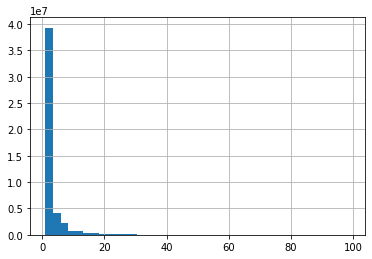

In [ ]:
data["Count"][data["Count"]<100].hist(bins=40)

Now, let's examine how the song distribution by genre.

In [ ]:
# Now looking into how many genres we have
genres["Main_genre"].describe()
# 15 unique genres

count     280831
unique        15
top         Rock
freq      113150
Name: Main_genre, dtype: object

In [ ]:
all_genres = genres["Main_genre"].unique().tolist()

cat = []
for i in all_genres:
  cat.append(np.sum(genres["Main_genre"]==i))

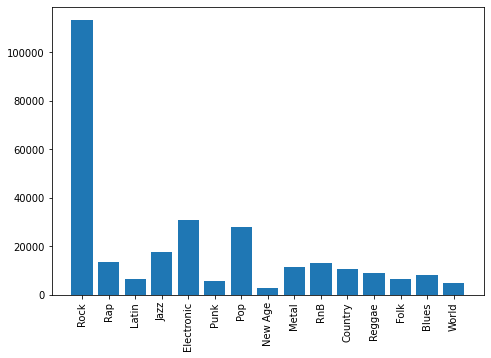

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = all_genres
val = cat
ax.bar(labels,val)
plt.xticks(rotation=90)
plt.show()
# Rock is the new pop?

# Merging the data

Merging the data so we could connect SongId with some metadata. Conducting the same data analysis below.

In [ ]:
mid_merge = pd.merge(left = genres, right = bridge, left_on="TrackId", right_on="TrackId")

In [ ]:
mid_merge.head()

,TrackId,Main_genre,Minor_genre,SongId,Artist,Song_name
0,TRAAAAK128F9318786,Rock,NaN,SOBLFFE12AF72AA5BA,Adelitas Way,Scream
1,TRAAAAW128F429D538,Rap,NaN,SOMZWCG12A8C13C480,Casual,I Didn't Mean To
2,TRAAABD128F429CF47,Rock,RnB,SOCIWDW12A8C13D406,The Box Tops,Soul Deep
3,TRAAADJ128F4287B47,Rock,NaN,SOCSNVI12A8C13ECC2,Big Brother & The Holding Company,Heartache People
4,TRAAADZ128F9348C2E,Latin,NaN,SOXVLOJ12AB0189215,Sonora Santanera,Amor De Cabaret


In [ ]:
print(mid_merge.shape)

(280831, 6)


In [ ]:
ganre_merge = pd.merge(left = mid_merge, right = data, left_on="SongId", right_on="SongId")

In [ ]:
ganre_merge.head()

,TrackId,Main_genre,Minor_genre,SongId,Artist,Song_name,UserId,Count
0,TRAAAAK128F9318786,Rock,NaN,SOBLFFE12AF72AA5BA,Adelitas Way,Scream,cf9a8225b3626e668facf9dda53a2ef3da445bf6,1
1,TRAAAAK128F9318786,Rock,NaN,SOBLFFE12AF72AA5BA,Adelitas Way,Scream,6776279a369a04148a92597d270ac500ddc7a27c,3
2,TRAAAAK128F9318786,Rock,NaN,SOBLFFE12AF72AA5BA,Adelitas Way,Scream,8c412b22910a9c9531ac72ec742913d73317782d,1
3,TRAAAAK128F9318786,Rock,NaN,SOBLFFE12AF72AA5BA,Adelitas Way,Scream,74230c5555c9f4e929f8e6c25344b7ee1f37d9e3,2
4,TRAAAAK128F9318786,Rock,NaN,SOBLFFE12AF72AA5BA,Adelitas Way,Scream,dac762704dfe74075187e98623f92268727bf749,1


## Merged data analysis

In [ ]:
print("Number of unique users", len(ganre_merge["UserId"].unique().tolist()),
      "Number of unique tracks", len(ganre_merge["SongId"].unique().tolist()))

Number of unique users 1018733 Number of unique tracks 173301


In [ ]:
pd.options.display.float_format = '{:.2f}'.format # supresing scientific notation
ganre_merge["Count"].describe()

count   30168816.00
mean           2.77
std            6.30
min            1.00
25%            1.00
50%            1.00
75%            2.00
max         9667.00
Name: Count, dtype: float64

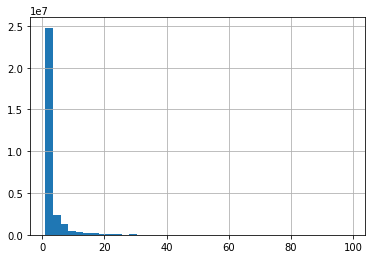

In [ ]:
ganre_merge["Count"][ganre_merge["Count"]<100].hist(bins=40)

In [ ]:
# Now looking into how many genres we have
ganre_merge["Main_genre"].describe()
# 15 unique genres

count     30168816
unique          15
top           Rock
freq      14922297
Name: Main_genre, dtype: object

In [ ]:
cat2 = []
for i in all_genres:
  cat2.append(np.sum(ganre_merge["Main_genre"]==i))

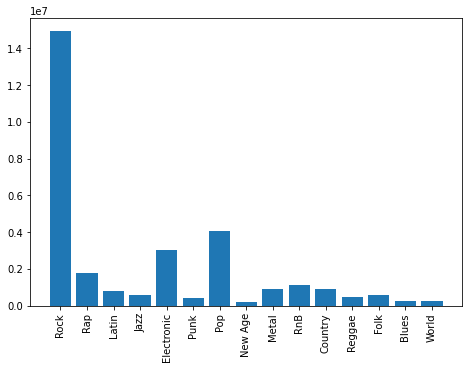

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = all_genres
val = cat2
ax.bar(labels,val)
plt.xticks(rotation=90)
plt.show()

Now we look into the Artist level metadata

In [ ]:
art_count = ganre_merge["Artist"].unique().tolist()
len(art_count)

21867

In [ ]:
sum_art = ganre_merge.groupby(["Artist"]).size()

In [ ]:
sum_art.describe()

count    21867.00
mean      1379.65
std       7036.85
min          1.00
25%         18.00
50%         95.00
75%        516.00
max     322535.00
dtype: float64

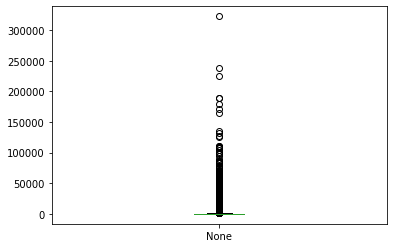

In [ ]:
sum_art.plot.box()

In [ ]:
sum_art[sum_art>100000]

Artist
Beirut                    101549
Björk                     108232
Black Eyed Peas           109747
Coldplay                  322535
Daft Punk                 179538
Eminem                    131666
Florence + The Machine    110397
Gorillaz                  106753
Guns N' Roses             103653
Harmonia                  110721
Jack Johnson              170619
John Mayer                125474
Justin Bieber             188485
Kings Of Leon             237685
Metallica                 135459
Muse                      164615
OneRepublic               109811
Radiohead                 189892
Rise Against              109212
The Black Keys            225624
The Killers               127043
dtype: int64

## Diagnostic merge

In [ ]:
mid_merge = pd.merge(left = data, right = bridge, left_on="SongId", right_on="SongId")

In [ ]:
mid_merge.head()

,UserId,SongId,Count,TrackId,Artist,Song_name
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove
1,7c86176941718984fed11b7c0674ff04c029b480,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove
2,76235885b32c4e8c82760c340dc54f9b608d7d7e,SOAKIMP12A8C130995,3,TRIQAUQ128F42435AD,Jack Johnson,The Cove
3,250c0fa2a77bc6695046e7c47882ecd85c42d748,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove
4,3f73f44560e822344b0fb7c6b463869743eb9860,SOAKIMP12A8C130995,6,TRIQAUQ128F42435AD,Jack Johnson,The Cove


In [ ]:
print("Number of unique songs:",len(mid_merge["SongId"].unique().tolist()), 
      "Number of unique users:", len(mid_merge["UserId"].unique().tolist()))

Number of unique songs: 384546 Number of unique users: 1019318


Nothing is lost.


In [ ]:
genres_merge = pd.merge(left = mid_merge, right = genres, left_on="TrackId", right_on="TrackId")

In [ ]:
print("Number of unique songs:",len(genres_merge["SongId"].unique().tolist()), 
      "Number of unique users:", len(genres_merge["UserId"].unique().tolist()))

Number of unique songs: 173301 Number of unique users: 1018733


Onyly 45% of the songs remain with 99.9% of the users. Why?

In [ ]:
artist_1dist = mid_merge.groupby(["Artist"]).size()

Only 52% of the artist remain. Which ones?

In [ ]:
if '!!!' in genres_merge["Artist"].values:
    print('Element exists in Dataframe')

In [ ]:
if 'Coldplay' in mid_merge["Artist"].values:
    print('Element exists in Dataframe')

Element exists in Dataframe
